In [1]:
from models import RMSELoss
from torch.utils.data import Dataset, DataLoader
import utils as ut
import torch
from datasets import FrameDataset
import train_nvidia_model as tnm
import os 
import numpy as np
import random 
import matplotlib.pyplot as plt
from torch import nn
import functools
import operator

In [2]:
#%matplotlib inline

In [3]:
seed = 1729 
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
#torch.use_deterministic_algorithms(True)

In [4]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(dev)

cuda


In [24]:
class NvidiaModel(nn.Module):
    def __init__(self, img_size: list[int]):
        super(NvidiaModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.BatchNorm2d(3),
            
            nn.Conv2d(3, 24, 5, 2),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2),

            nn.Conv2d(24, 36, 5, 2),
            nn.BatchNorm2d(36),
            nn.ReLU(),

            nn.Conv2d(36, 48, 5, 2),
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.Conv2d(48, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # nn.Conv2d(64, 128, 3, 2),
            # nn.BatchNorm2d(128),
            # nn.ReLU(),

            # nn.Conv2d(128, 256, 3, 2),
            # nn.BatchNorm2d(256),
            # nn.ReLU(),


            # nn.AdaptiveAvgPool2d(1),
            nn.AvgPool2d(2),

            nn.Flatten(1)
        )
        h, w = img_size
        out = self.cnn(torch.zeros(1, 3, h, w))
        self.cnn_shape_out = functools.reduce(operator.mul, list(out.shape))
        
        #self.dropout = nn.Dropout(0.5)

        self.linear = nn.Sequential(
            nn.Linear(self.cnn_shape_out, 1024),
            nn.ReLU(), 
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(), 
            nn.Linear(16, 2),
        )

    def forward(self, X):
        out = self.cnn(X)
        #out = self.dropout(out)
        out = self.linear(out)
        return out

In [6]:
# class FrameDataset(Dataset):
#     def __init__(self, frames_dir, angles_file, start_idx, end_idx):
#         self.frames = ut.load_frames(frames_dir, start_idx, end_idx)
#         self.angles = torch.tensor(ut.read_angles(angles_file)[start_idx:end_idx])

#     def __getitem__(self, idx):
#         return (self.frames[idx], self.angles[idx])

#     def __len__(self):
#         return len(self.angles)

In [7]:
data_dir = "data_h3_w3"
videos = [0, 1]
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")
train_dirs = [os.path.join(train_dir, str(video)) for video in videos]
valid_dirs = [os.path.join(valid_dir, str(video)) for video in videos]
test_dirs = [os.path.join(test_dir, str(video)) for video in videos]
train_angles_files = [os.path.join(td, "angles.txt") for td in train_dirs]
valid_angles_files = [os.path.join(vd, "angles.txt") for vd in valid_dirs]
test_angles_files = [os.path.join(td, "angles.txt") for td in test_dirs]

In [8]:
# basic_train_dir = os.path.join(data_dir, "basic_train/0")
# a = os.path.join(basic_train_dir, "angles.txt")
# ds = FrameDataset(basic_train_dir, a, 0, 10)
# def show_img(img, t=None):
#     if t is not None:
#         img = t(img)
#     plt.imshow(img.permute(1, 2, 0))

In [9]:
train_datasets = [FrameDataset(frame_dir, angles_file) for frame_dir, angles_file in zip(train_dirs, train_angles_files)]
valid_datasets = [FrameDataset(frame_dir, angles_file) for frame_dir, angles_file in zip(valid_dirs, valid_angles_files)]
test_datasets = [FrameDataset(frame_dir, angles_file) for frame_dir, angles_file in zip(test_dirs, test_angles_files)]

In [10]:
batch_size = 32

def seed_worker(worker_id):
    # worker_seed = torch.initial_seed() % 2**32
    worker_seed = seed
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

w = torch.Generator()
w.manual_seed(seed)

t = torch.Generator()
t.manual_seed(seed)


train_dataloaders = [DataLoader(train_ds, batch_size, worker_init_fn=seed_worker, generator=g) for train_ds in train_datasets]
valid_dataloaders = [DataLoader(valid_ds, 1, worker_init_fn=seed_worker, generator=w) for valid_ds in valid_datasets]
test_dataloaders = [DataLoader(test_ds, 1, worker_init_fn=seed_worker, generator=t) for test_ds in test_datasets]

In [11]:
img_size = (120, 360)

In [25]:
model = NvidiaModel(img_size)
model.to(dev)
opt = torch.optim.AdamW(model.parameters(), lr=3e-04)
loss = RMSELoss()
history = tnm.History("test_1", videos, model, opt, loss, None, batch_size)
epochs = 30
tnm.fit(epochs, history, train_dataloaders, valid_dataloaders, dev, verbose=True)

Start epoch #0...
Train_loss: 0.0839231946039945
Val_loss: 0.06062042138849695
Epoch complete in 0m 5s

Start epoch #1...
Train_loss: 0.025078581009681026
Val_loss: 0.027648102235980333
Epoch complete in 0m 5s

Start epoch #2...
Train_loss: 0.019718022271990775
Val_loss: 0.04850208741457512
Epoch complete in 0m 5s

Start epoch #3...
Train_loss: 0.02807484072012206
Val_loss: 0.02471563662402332
Epoch complete in 0m 5s

Start epoch #4...
Train_loss: 0.02685373133669297
Val_loss: 0.03040761529215767
Epoch complete in 0m 5s

Start epoch #5...
Train_loss: 0.022338220760381472
Val_loss: 0.03898848972942991
Epoch complete in 0m 5s

Start epoch #6...
Train_loss: 0.02743787793442607
Val_loss: 0.028955645859241486
Epoch complete in 0m 5s

Start epoch #7...
Train_loss: 0.02565789211851855
Val_loss: 0.05223591271011779
Epoch complete in 0m 5s

Start epoch #8...
Train_loss: 0.03407361524878069
Val_loss: 0.03431376578325095
Epoch complete in 0m 5s

Start epoch #9...
Train_loss: 0.020914359561478097


In [28]:
model.cnn_shape_out

4864

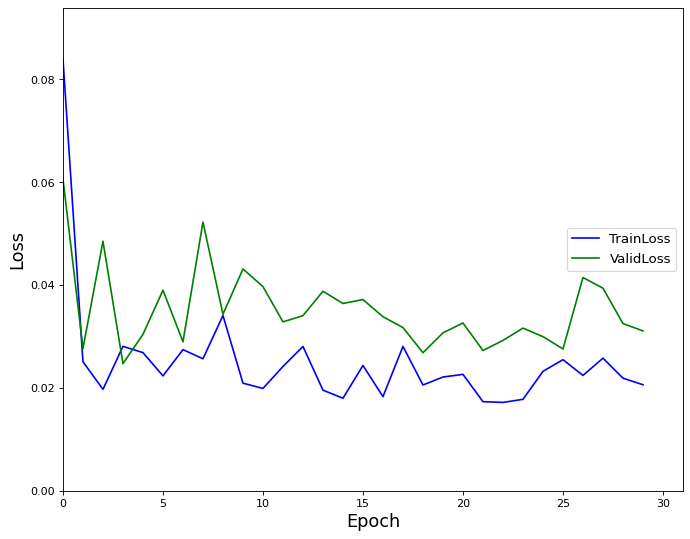

In [26]:
history.save_training_info()

'YOUR ERROR SCORE IS 0.51% (lower is better)'

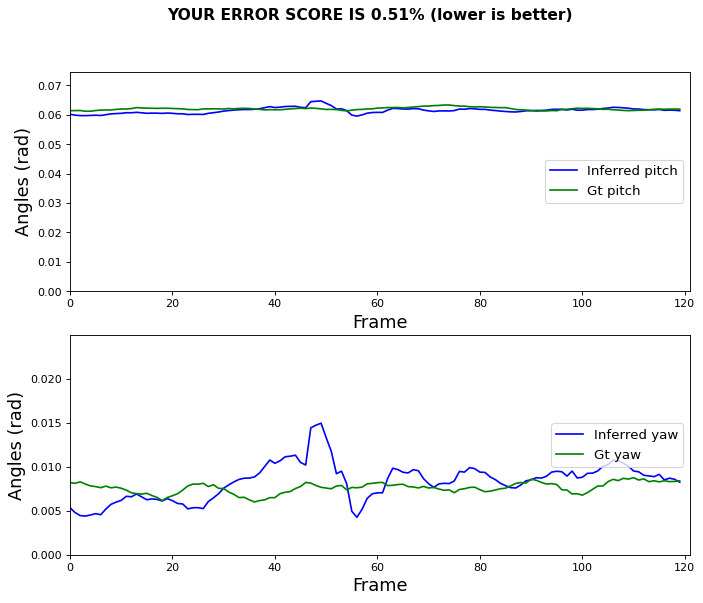

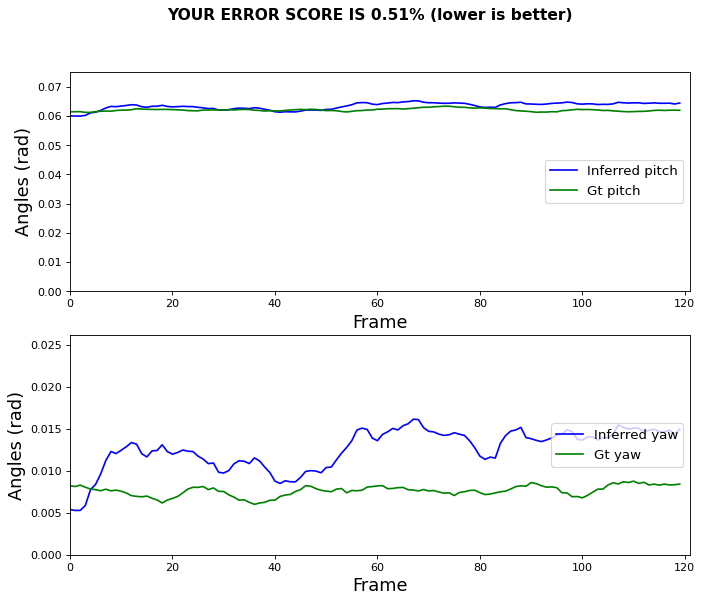

In [27]:
history.test_model(test_dataloaders, dev)